# Using FFTs to remove the seasonal cycle
#### by Elizabeth Barnes

This example goes through step-by-step how to calculate (and remove) the seasonal cycle from a time series using FFTs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 8.0/2)

# specify whether running on Colab or locally
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


### Get your data together

*Note: The data file can be downloaded [here](https://github.com/eabarnes1010/ats655-coursematerial/blob/master/jupyter_notebooks/data/z500_daily.mat)*

In [2]:
# keep this commented out - for re-saving data

# DATA = sio.loadmat('data/z500_daily.mat')
# TIME = DATA['TIME']
# X = DATA['X']
# print('data is loaded.')

# X = X[:,15,110] #latitude = 45N, longitude = 330E
# np.savez('data/z500_daily_45N_330E.npz', X=X, TIME=TIME)


In [3]:
if(IN_COLAB == True):
    !wget https://github.com/eabarnes1010/ats655-coursematerial/raw/master/jupyter_notebooks/data/z500_daily_45N_330E.npz
    da = np.load('z500_daily_45N_330E.npz')
else:
    da = np.load('data/z500_daily_45N_330E.npz')

X = da['X']
TIME = da['TIME']
print(X.shape)

(12297,)


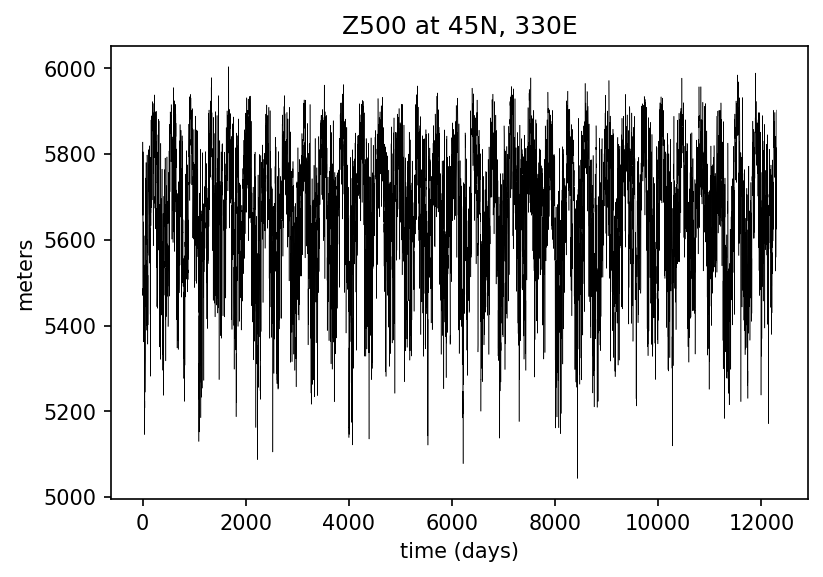

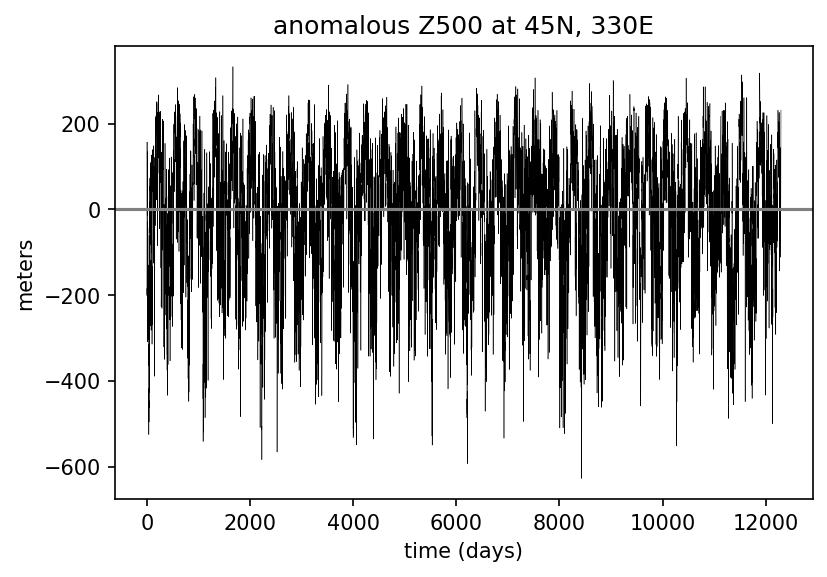

In [4]:
#%% plot full time series
plt.figure()
plt.plot(np.arange(0,np.size(X)),X,'-k', linewidth = .25)
plt.ylabel('meters')
plt.xlabel('time (days)')
plt.title('Z500 at 45N, 330E')
plt.show()

#%% plot anomalous time series
plt.figure()
plt.plot(np.arange(0,np.size(X)),X-np.mean(X),'-k', linewidth = .25)
plt.axhline(y=0,color='gray')
plt.ylabel('meters')
plt.xlabel('time (days)')
plt.title('anomalous Z500 at 45N, 330E')
plt.show()


In [5]:
# calculate the daily climatology (i.e. calendar days means)
TIME_climate = np.vstack({tuple(row) for row in TIME[:,2:4]})
TIME_climate = TIME_climate[np.lexsort((TIME_climate[:,1],TIME_climate[:,0])),:]

days_in_year = np.size(TIME_climate, axis=0)
Yclim = np.empty(days_in_year)
Yclim[:] = np.NAN

for iday in np.arange(0,days_in_year):
    month = TIME_climate[iday,0]
    day = TIME_climate[iday,1]

    t = np.where(np.logical_and(TIME[:,2]==month,TIME[:,3]==day))
    Yclim[iday] = np.nanmean(X[t])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


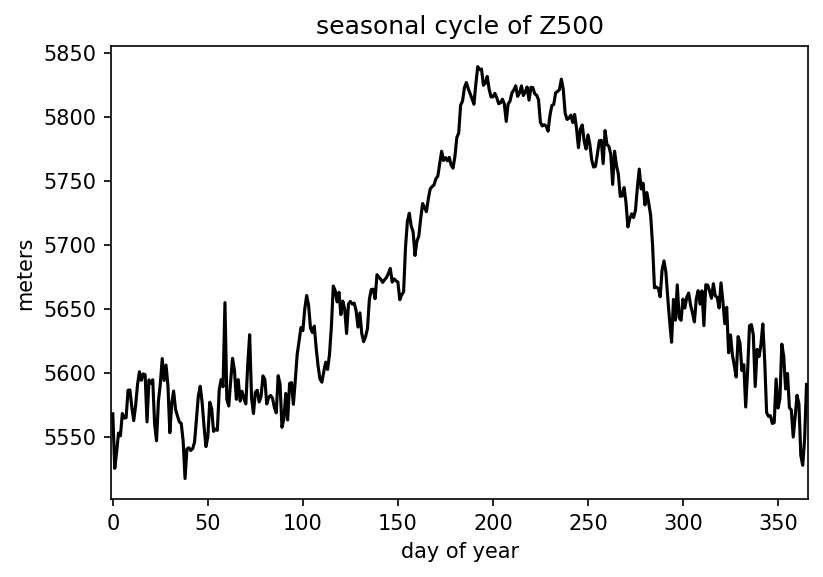

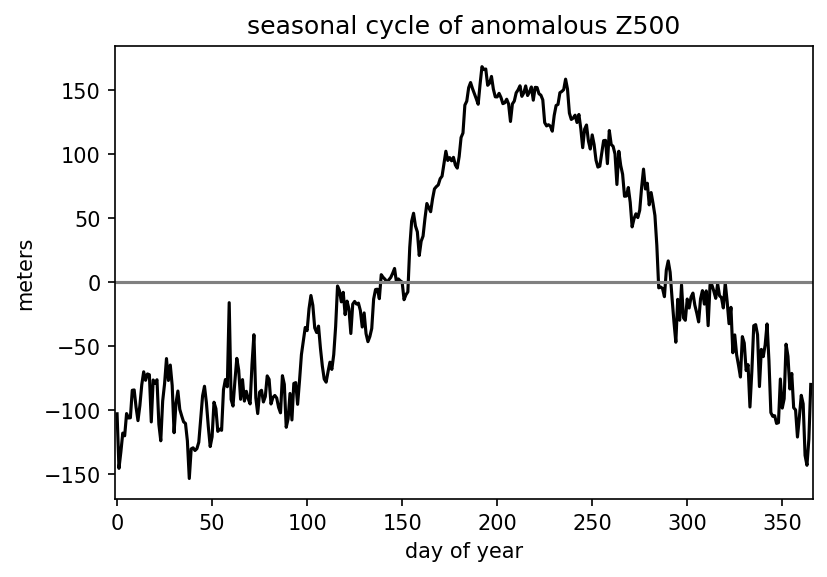

In [6]:
# plot seasonal cycle with all of the daily wiggles
plt.figure()
plt.plot(np.arange(0,np.size(Yclim)),Yclim,'-k')
plt.ylabel('meters')
plt.xlabel('day of year')
plt.xlim(-1,366)
plt.title('seasonal cycle of Z500')
plt.show()

# plot seasonal cycle of anomalous Z500 with all of the daily wiggles
Xa = Yclim - np.mean(Yclim);

plt.figure()
plt.plot(np.arange(0,np.size(Xa)),Xa,'-k')
plt.ylabel('meters')
plt.xlabel('day of year')
plt.xlim(-1,366)
plt.title('seasonal cycle of anomalous Z500')
plt.axhline(y=0,color='gray')
plt.show()

### Calculate the FFT of the data

In [7]:
#%% calculate the FFT of the data to find the seasonal cycle

# As an example, uncomment below if you want to see what happens if you
# don't remove the mean of the time series
#Xa = Yclim;
Z = np.fft.fft(Xa)

# to get the right variance, need to normalize by the length of the time
# series, however, don't want to to do this if inputting back into "ifft"
Yfft = Z/np.size(Yclim);

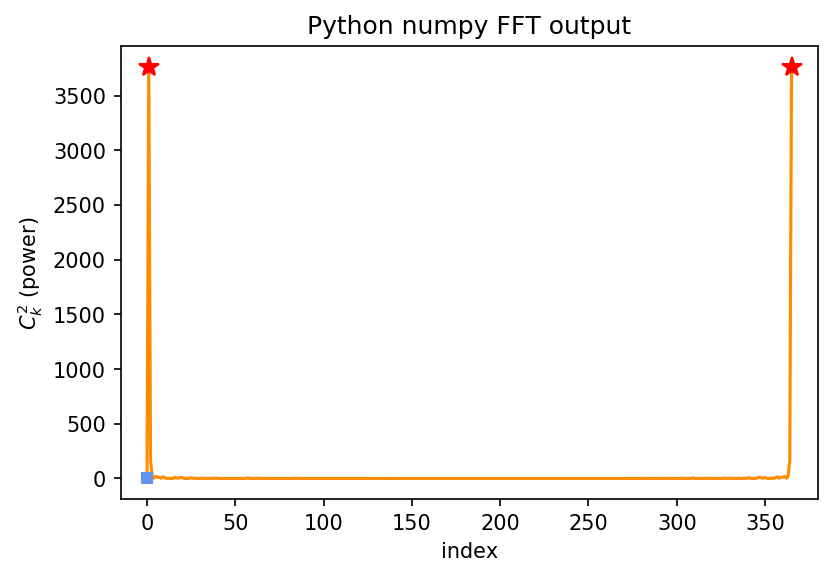

In [8]:
plt.figure()
plt.plot(np.arange(0,np.size(Yfft)),np.abs(Yfft)**2, color = 'darkorange')
plt.plot(0,np.abs(Yfft[0])**2.,'s',color = 'cornflowerblue',markersize=5)
plt.plot(1,np.abs(Yfft[1])**2.,'*r',markersize=10)
plt.plot(np.size(Yfft)-1,np.abs(Yfft[-1])**2.,'*r',markersize=10)

plt.xlabel('index')
plt.ylabel('$C_k^2$ (power)')

plt.title('Python numpy FFT output')

plt.xlim(-15,365+15)
plt.show()

A few important notes here for our data: 
* the power of the mean is given by the blue square (it is zero if we subtract the mean from our data initially)
* the power of the lowest frequency is given the the red stars - it is split symmetrically in the array Yfft output by python's FFT function

General comments:
* the power is distributed symmetrically in the matrix (this appears to be true for most software I have seen)
* the first index refers to the mean (and this is _not_ symmetric)
* the second index is then the same as the last index
* the third index is then the same as the second-to-last index
* etc.



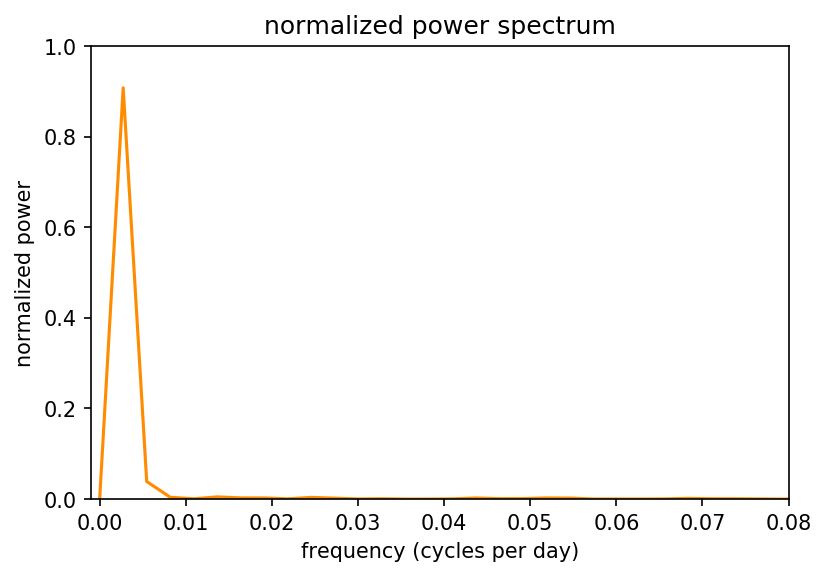

In [9]:
# combine symmetric parts of the FFT and plot the power spectrum as a function of frequency
freq = np.arange(0,np.size(Yclim)/2+1)/float(np.size(Yclim))

# the factor of 2 in front is needed or the sum won't equal the total variance of X
Ck2 = 2.*np.abs(Yfft[0:int(np.size(Yclim)/2)+1])**2 

plt.figure()
plt.plot(freq,Ck2/np.sum(Ck2),'-', color = 'darkorange', label = 'original spectrum')
plt.ylabel('normalized power')
plt.xlabel('frequency (cycles per day)')
plt.xlim(-.001,.08)
plt.title('normalized power spectrum')
plt.ylim(0,1.0)
plt.show()

It is clear from this power spectrum that _a lot_ of the power resides at the lowest-frequencies (i.e. the seasonal cycle). Note that if we have already subtracted the mean from our data, the power at freq = 0.0 is zero.

In [10]:
# checking that the variance compared to the total variance in our spectrum
# (Parseval's Theorem)

# actual variance of our data
var_actual = np.var(Xa)

# variance in our spectrum, it should be close to the actual variance of our data
a = Yfft[np.arange(0,int(np.size(Yclim)/2)+1)]
s=np.sum(a[1::]*np.conj(a[1::])); # don't want to include the mean, since this is not in the variance calculation
var_spectrum = np.real(2*s) # multiply by two in order to conserve variance

print('variance actual = ' + str(var_actual) )
print('variance spect. = ' + str(var_spectrum) )

variance actual = 8294.28473719378
variance spect. = 8294.454547617406


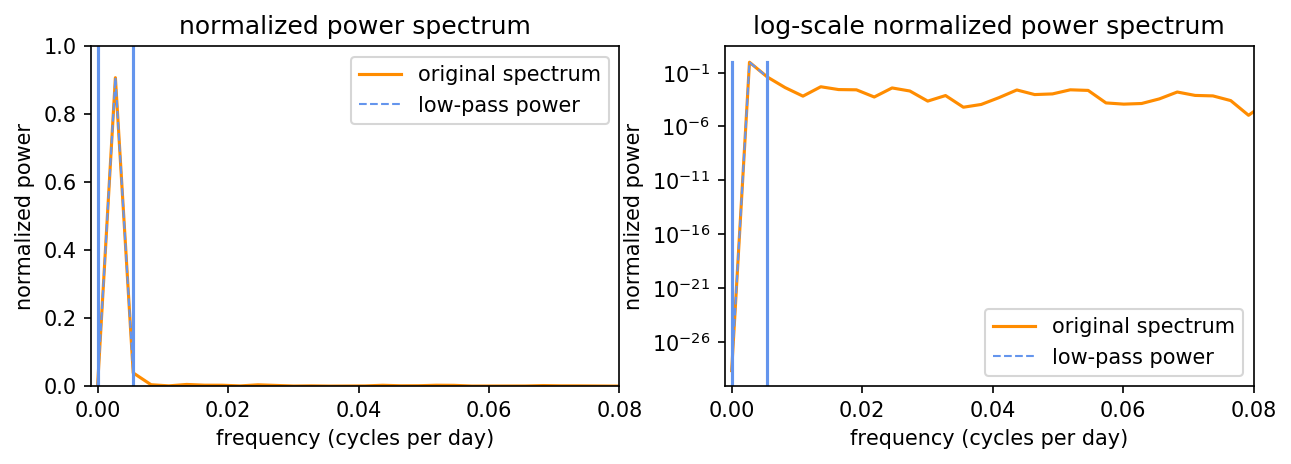

In [11]:
# plot spectrum and how we will only retain the first 3 harmonics (which includes the mean)
# alternatively, we can only exclude the low frequencies (first 3 harmonics = mean + 2 lowest frequencies) 

#**********TRY TO MODIFY**************
numHarm = 3
#*************************************


plt.figure(figsize=(10,3))

#------- linear scale -------
plt.subplot(1,2,1)
plt.plot(freq,Ck2/np.sum(Ck2),'-', color = 'darkorange', label = 'original spectrum')
plt.ylabel('normalized power')
plt.xlabel('frequency (cycles per day)')
plt.xlim(-.001,.08)
plt.title('normalized power spectrum')
plt.ylim(0,1.0)

plt.plot((0,0),(0,1),'-', color = 'cornflowerblue', linewidth = 1.5)
plt.plot((freq[numHarm-1],freq[numHarm-1]),[0,1],'-', color = 'cornflowerblue', linewidth = 1.5)

A = Ck2/np.sum(Ck2)
A[numHarm::] = 0.
plt.plot(freq[0:numHarm],A[0:numHarm],'--', color = 'cornflowerblue' ,linewidth = 1, label = 'low-pass power')

plt.yscale('linear')
plt.legend()

#------- log scale -------
plt.subplot(1,2,2)
plt.plot(freq,Ck2/np.sum(Ck2),'-', color = 'darkorange', label = 'original spectrum')
plt.ylabel('normalized power')
plt.xlabel('frequency (cycles per day)')
plt.xlim(-.001,.08)
plt.title('log-scale normalized power spectrum')
# plt.ylim(0,1.0)

plt.plot((0,0),(0,1),'-', color = 'cornflowerblue', linewidth = 1.5)
plt.plot((freq[numHarm-1],freq[numHarm-1]),[0,1],'-', color = 'cornflowerblue', linewidth = 1.5)

A = Ck2/np.sum(Ck2)
A[numHarm::] = 0.
plt.plot(freq[0:numHarm],A[0:numHarm],'--', color = 'cornflowerblue' ,linewidth = 1, label = 'low-pass power')

plt.yscale('log')
plt.legend()

plt.show()

In [12]:
# low pass filter the data;
# i.e. retain only the mean and the first two harmonics - set all other frequencies to zero
Zlow = np.copy(Z)
Zlow[numHarm:-(numHarm-1):] = 0.0
X_lowpass = np.real(np.fft.ifft(Zlow))

# OR - high pass filter the data;
# i.e. retain only the mean and the first two harmonics - set all other frequencies to zero
Zhigh = np.copy(Z)
Zhigh[0:numHarm:] = 0.
Zhigh[-(numHarm-1)::] = 0.
X_highpass = np.real(np.fft.ifft(Zhigh))

### Plot the resulting seasonal cycle and its components

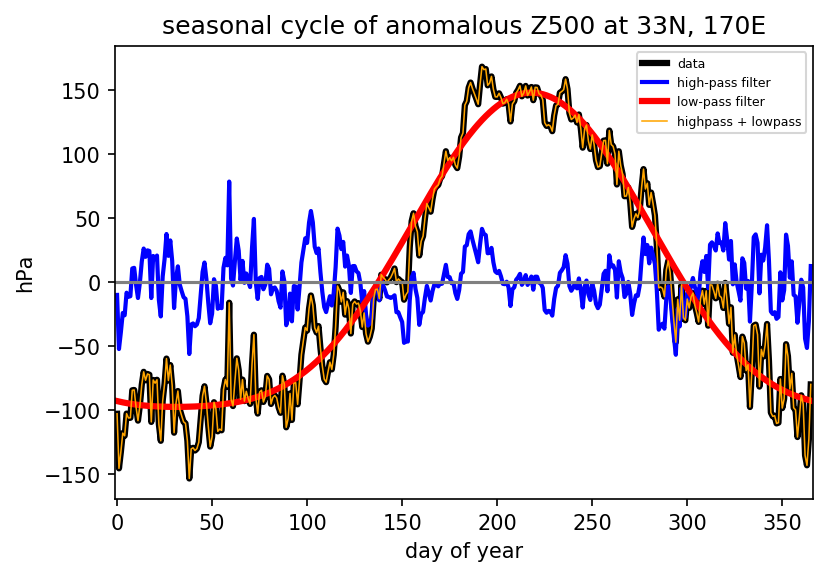

In [13]:
plt.figure()

# plot raw anomalous daily-climatology
plt.plot(np.arange(0,np.size(Xa)),Xa,'-k', label = 'data', linewidth = 3)

# plot raw high-pass
plt.plot(np.arange(0,np.size(Xa)),X_highpass,'-b',linewidth = 2, label='high-pass filter')

# plot smoothed seasonal cycle (smoothed low-pass)
plt.plot(np.arange(0,np.size(Xa)),X_lowpass,'-r',linewidth = 3, label ='low-pass filter')

# plot low pass+high pass
plt.plot(np.arange(0,np.size(Xa)),X_lowpass+X_highpass,'-',color = 'orange',linewidth = .75, \
         label = 'highpass + lowpass')

plt.axhline(y=0,color='gray')
plt.legend(fontsize = 6)
plt.ylabel('hPa')
plt.xlabel('day of year')
plt.xlim(-1,366)
plt.title('seasonal cycle of anomalous Z500 at 33N, 170E')

plt.show()

Notice that the sum of the high-pass filter and low-pass filter gives us our original raw seasonal cycle. This is showing that you can always "re-create" your data assuming you have evenly split it into high- and low-pass components. 

### Remove the seasonal cycle
In this final step, we can remove our seasonal cycle (i.e. the smoothed low-pass data, red curve above). To do this, we just loop through our data and subtract the seasonal cycle value (red curve above) from each calendar day.

In [14]:
# initialize array to hold de-seasonalized data
X_no_sc = np.zeros(np.shape(X))

for iday in np.arange(0,days_in_year):
    month = TIME_climate[iday,0]
    day = TIME_climate[iday,1]
    t = np.where(np.logical_and(TIME[:,2]==month,TIME[:,3]==day))
    X_no_sc[t] = (X[t]-np.mean(X)) - X_lowpass[iday]

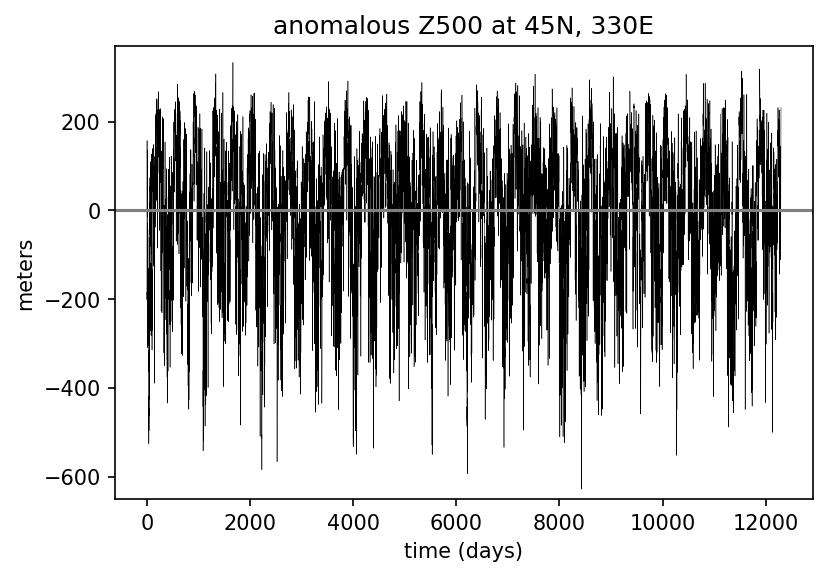

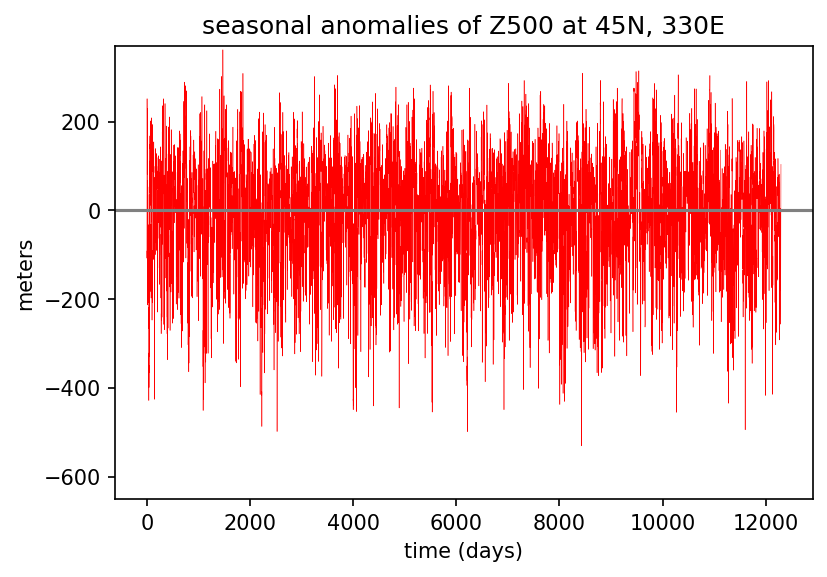

In [15]:
#%% plot raw anomalous time series
plt.figure()
plt.plot(np.arange(0,np.size(X)),X-np.mean(X),'-k', linewidth = .25)
plt.axhline(y=0,color='gray')
plt.ylabel('meters')
plt.xlabel('time (days)')
plt.title('anomalous Z500 at 45N, 330E')
plt.ylim(-650, 370)
plt.show()

#%% plot anomalous time series with seasonal cycle removed
plt.figure()
plt.plot(np.arange(0,np.size(X)),X_no_sc,'-r', linewidth = .25)
plt.axhline(y=0,color='gray')
plt.ylabel('meters')
plt.xlabel('time (days)')
plt.title('seasonal anomalies of Z500 at 45N, 330E')
plt.ylim(-650, 370)
plt.show()

As expected, our data still has all of the lovely wiggles that we might want to analyze, but the seasonal cycle has been removed!

*To see any updated versions of this notebook, visit https://github.com/eabarnes1010/ats655-coursematerial/blob/master/jupyter_notebooks/seasonal_cycle_filtering.ipynb*